# Train Hugginface Transformer

Trains Transformers from huggingface on the sentiment dataset

In [1]:
# To allow importing modules from src
import sys
import os

# Get the absolute path of the 'src' directory
src_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add 'src' directory to the Python path
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
# Import necessary libraries
import itertools
import datetime
import re

import torch
from torch.utils.data import DataLoader
from torch.utils import tensorboard as tb  # To run: tensorboard --logdir=runs
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler

from tqdm.auto import tqdm

from lr_finder import LRFinder
from helpers import (
    SentimentDataset, SENTIMENT_TO_ID, ID_TO_SENTIMENT, 
    save_model, load_model, test_accuracy
)

### Constants and hyperparameters

In [3]:

# Which transformer model to use? Alternatives: "albert-base-v2", "albert-large-v2", "bert-large-uncased"
# "roberta-base", "distilbert-base-uncased", "facebook/bart-base", "google/fnet-base", "bert-base-uncased"
MODEL_NAME = "distilbert-base-uncased"  
MAX_LEN = 35  # Sentence length for padding

NUM_EPOCHS = 3
LR = 10e-5
WEIGHT_DECAY = 10e-5
BATCH_SIZE = 50

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
now = datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S")
file_name = f'{os.path.basename(MODEL_NAME)}-sentiment {now}'

device

### Training Helper Functions

In [4]:
def collate_batch(batch, tokenizer, max_length=25):
    """Process a batch of data to its proper form."""
    # Feature should be batch_size * num_words * num_vocabs
    features, labels = zip(*batch)
    features = tokenizer(features, add_special_tokens=True, max_length=max_length, 
                         padding="max_length", truncation=True, return_tensors="pt")
    labels = torch.stack(labels)
    return features, labels

In [5]:
def train_model(
    model, optimizer, train_loader, test_loader, writer, num_epochs, 
    scheduler=None, criterion=None, device='cuda', start_iter=0
):
    test_iter = itertools.cycle(iter(test_loader))
    num_batches = len(train_loader)
    writer.add_text('Hyperparameters', f'num_epochs: {num_epochs}, num_batches: {num_batches}')

    progress_bar = tqdm(range(num_epochs*num_batches))
    epoch_bar = tqdm(range(num_epochs))
    for epoch in range(0, num_epochs):
        batch_idx = 0
        for train_batch in train_loader:
            train_loss, train_accuracy = _train_one_round(train_batch, model, optimizer, 
                                                          scheduler, criterion, device)

            if batch_idx % 10 == 0:
                test_batch = next(test_iter)
                test_loss, test_accuracy = _evaluate_one_round(test_batch, model, device)
                gradient_norm = _get_gradient_norm(model)
                lr = _get_learning_rate(optimizer, scheduler)

                n_iter = batch_idx + num_batches * epoch + start_iter
                _write_to_tboard(writer, n_iter, train_loss, test_loss, train_accuracy, 
                                 test_accuracy, gradient_norm, lr)
            batch_idx += 1
            progress_bar.update(1)
        epoch_bar.update(1)


def _train_one_round(batch, model, optimizer, scheduler=None, criterion=None, device='cuda'):
    optimizer.zero_grad()
    features, targets = batch
    features = features.to(device=device)
    targets = targets.to(device=device)

    output = model(**features, labels=targets)
    if criterion:
        loss = criterion(output.logits, targets)
    else:
        loss = output.loss
    loss.backward()
    optimizer.step()
    if scheduler is not None:
        scheduler.step()

    accuracy = _accuracy(output, targets)
    del features, targets, output
    return loss, accuracy


def _evaluate_one_round(batch, model, device='cuda'):
    features, targets = batch
    features = features.to(device=device)
    targets = targets.to(device=device)

    with torch.no_grad():
        output = model(**features, labels=targets)
        loss = output.loss
        accuracy = _accuracy(output, targets)
    del features, targets, output
    return loss, accuracy


def _accuracy(output, target):
    with torch.no_grad():
        logits = output.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        accuracy = (probs.argmax(dim=1) == target).sum().item() / len(target)
    return accuracy


def _get_gradient_norm(model):
    """Computes the gradient norm of a model. I.e. the sum of the size of all gradients"""
    total_norm = 0
    for p in model.parameters():
        param_norm = p.grad.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm


def _get_learning_rate(optimizer, scheduler):
    if scheduler:
        lr = torch.log10(torch.tensor(scheduler.get_last_lr()[0])).item()
    else:
        lr = torch.log10(torch.tensor(optimizer.param_groups[0]['lr'])).item()
    return lr


def _write_to_tboard(writer, n_iter, train_loss, test_loss, 
                     train_accuracy, test_accuracy, gradient_norm, lr=None):
    writer.add_scalar('Train loss', train_loss, n_iter)
    writer.add_scalar('Test loss', test_loss, n_iter)
    writer.add_scalar('Train accuracy', train_accuracy, n_iter)
    writer.add_scalar('Test accuracy', test_accuracy, n_iter)
    writer.add_scalar('Gradient norm', gradient_norm, n_iter)
    if lr:
        writer.add_scalar('Log learning rate', lr, n_iter)

### Load model and data

In [6]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding="max_length", truncation=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=3, id2label=ID_TO_SENTIMENT, label2id=SENTIMENT_TO_ID
)
model = model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

In [7]:
train_set = SentimentDataset('../../data/fixed-data/sentiment-train.csv')
test_set = SentimentDataset('../../data/fixed-data/sentiment-val.csv')

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, 
                          collate_fn=lambda x: collate_batch(x, tokenizer, max_length=MAX_LEN))
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, 
                         collate_fn=lambda x: collate_batch(x, tokenizer, max_length=MAX_LEN))

### Training

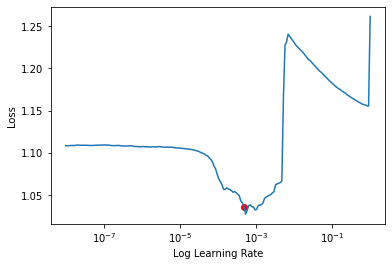

0.000475744112974792

In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-8, weight_decay=WEIGHT_DECAY)
lrfinder = LRFinder(model, optimizer, criterion=None, device=device)
lrfinder.run(train_loader, init_value=1e-8, final_value=1, beta=0.02)
best_lr = lrfinder.plot()
lrfinder.reset()
best_lr

In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=NUM_EPOCHS * len(train_loader)
)

writer = tb.SummaryWriter(f'../../runs/{file_name}')
train_model(model, optimizer, scheduler=lr_scheduler, criterion=None,
            num_epochs=NUM_EPOCHS, train_loader=train_loader, test_loader=test_loader, 
            device=device, writer=writer)

  0%|          | 0/21216 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

### Storing and Evaluating the Model

In [10]:
save_model(model, f'../../models/{file_name}.pth')

In [11]:
test_accuracy(model, test_loader, device=device)

Test size: 15518
Baseline accuracy: 35.53 %
Accuracy: 82.10 %


In [12]:
def predict_str(model, sentence):
    model.eval()
    with torch.no_grad():
        tokens = sentence_pipeline(sentence)
        tokens = tokens.to(device=device)
        preds = model(**tokens)
        probs = torch.nn.functional.softmax(preds.logits, dim=1)
        yhat = probs.argmax(dim=1)
        return ID_TO_SENTIMENT[yhat.item()]
    

def sentence_pipeline(sentence):
    sentence = _clean_text(sentence)
    features = tokenizer([sentence], add_special_tokens=True, max_length=MAX_LEN, 
                         padding="max_length", truncation=True, return_tensors="pt")
    return features
    

def _clean_text(headline: str):
    headline = str(headline).lower()
    headline = re.sub(r'[^a-zA-Z0-9.,?!-]', ' ', headline)
    headline = re.sub(r'\s+', ' ', headline)
    headline = re.sub('- analyst blog', '', headline)
    headline = headline.strip()
    return headline

pos = predict_str(model, "Inflation stable as the stock market rises to an all time high")
neu = predict_str(model, "Stock market finished side-ways for the day as GDP reports are released")
neg = predict_str(model, "Inflation rampant as stocks keep crashing")
print(f"Label vs model prediction\n- Positive: {pos}\n- Neutral: {neu}\n- Negative: {neg}")

Label vs model prediction
- Positive: Neutral
- Neutral: Neutral
- Negative: Negative


In [ ]:
# To load a previously saved model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding="max_length", truncation=True)
model = load_model(model, '../../models/distilbert-base-uncased 2023-05-05 11-17-06.pth', device)